In [740]:
import csv
import random
import math
import operator

import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [741]:
stock = 'aapl'

df = pd.read_csv('%s.us.txt' % stock, index_col=0)
df.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
print(df.shape)
df.head()

(8364, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062


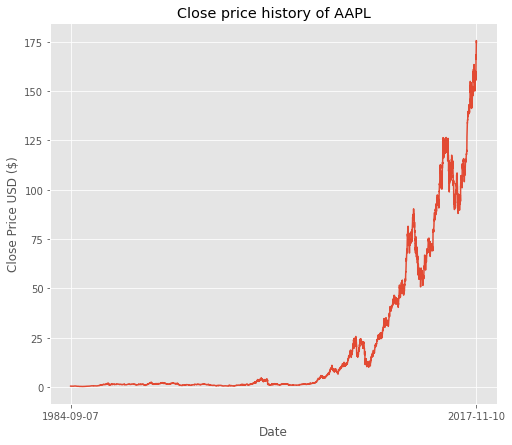

In [742]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

## 1. Exploring Rolling Mean and Return Rate of Stocks
In this analysis, we analyse stocks using two key measurements: Rolling Mean and Return Rate.

### Rolling Mean (Moving Average) — to determine trend

Rolling mean/Moving Average (MA) smooths out price data by creating a constantly updated average price. This is useful to cut down “noise” in our price chart. Furthermore, this Moving Average could act as “Resistance” meaning from the downtrend and uptrend of stocks you could expect it will follow the trend and less likely to deviate outside its resistance point.

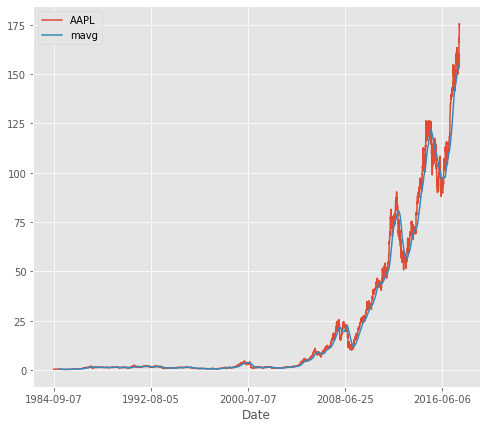

In [743]:
# Calculate the Moving Average for the last 100 windows (100 days) of stocks closing price and take the average for each of the window’s moving average.
close_px = df['Close']
mavg = close_px.rolling(window=100).mean()

# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

The Moving Average makes the line smooth and showcase the increasing or decreasing trend of stocks price.
In this chart, the Moving Average showcases increasing trend the upturn or downturn of stocks price. Logically, you should buy when the stocks are experiencing downturn and sell when the stocks are experiencing upturn.

### Return Deviation — to determine risk and return

Expected Return measures the mean, or expected value, of the probability distribution of investment returns. The expected return of a portfolio is calculated by multiplying the weight of each asset by its expected return and adding the values for each investment.

<AxesSubplot:xlabel='Date'>

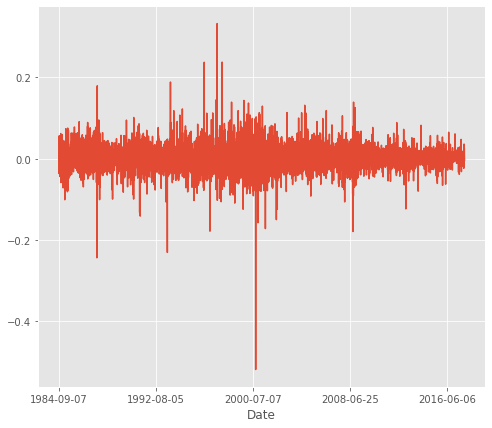

In [744]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

Logically, our ideal stocks should return as high and stable as possible.

## 2. Predicting Stocks Price.

### Feature Engineering

We will use K Nearest Neighbor (KNN) to predict our stocks. 

We will first engineer 2 new features: High Low Percentage and Percentage Change.

In [745]:
dfreg = df.loc[:,['Close','Volume']]
dfreg['HL_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['Percent_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.head(10)

,Close,Volume,HL_Percent,Percent_Change
Date,,,,
1984-09-07,0.42388,23220030,2.425215,0.000000
1984-09-10,0.42134,18022532,2.729387,-0.599226
1984-09-11,0.42902,42498199,2.685190,0.907893
1984-09-12,0.41618,37125801,3.697919,-2.992867
1984-09-13,0.43927,57822062,0.284563,0.000000
1984-09-14,0.44566,68847968,3.448817,1.166803
1984-09-17,0.45718,53755262,1.397699,0.000000
1984-09-18,0.44052,27136886,4.655861,-3.644079
1984-09-19,0.43157,29641922,3.264824,-2.031690


### Pre-processing & Data split

We will clean up and process the data using the following steps before putting them into the prediction models:
1. Drop missing value
2. Separating the label here, we want to predict the Close
3. Scale the X so that everyone can have the same distribution
4. Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Separation of training and testing of model by train test split

In [746]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the Close
forecast_col = 'Close'
dfreg['Label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['Label'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
#X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['Label'])
y = y[:-forecast_out]

# Separation of training and testing of model by train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### K Nearest Neighbour (KNN) - Evaluation (Regression)

In [747]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=7, metric="euclidean")
clfknn.fit(X_train, y_train)

print('kNN accuracy for training set: %f' % clfknn.score(X_train, y_train))
print('kNN accuracy for test set: %f' % clfknn.score(X_test, y_test))

kNN accuracy for training set: 0.983986
kNN accuracy for test set: 0.971944


Above shows an accuracy score (>0.95) for our KNN model. Below is a gragh to help us visualise the data better.

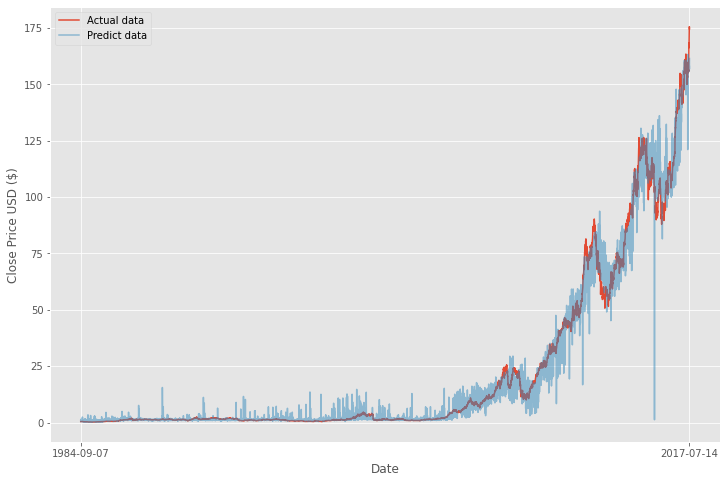

In [748]:
y_val = dfreg[:-forecast_out]
y_val_pred = clfknn.predict(X)
val1 = dfreg[:-forecast_out].copy()
val1['Label'] = np.ravel(y_val_pred)

plt.figure(figsize=(12,8))
plt.plot(y_val['Label'], label='Actual data')
plt.plot(val1['Label'], label='Predict data', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(y_val.index.values)[0], list(y_val.index.values)[-1]])
plt.legend()
plt.show()


Using our model, we can forecast and predict future stocks pricing. We will visualize the plot with our existing historical data.

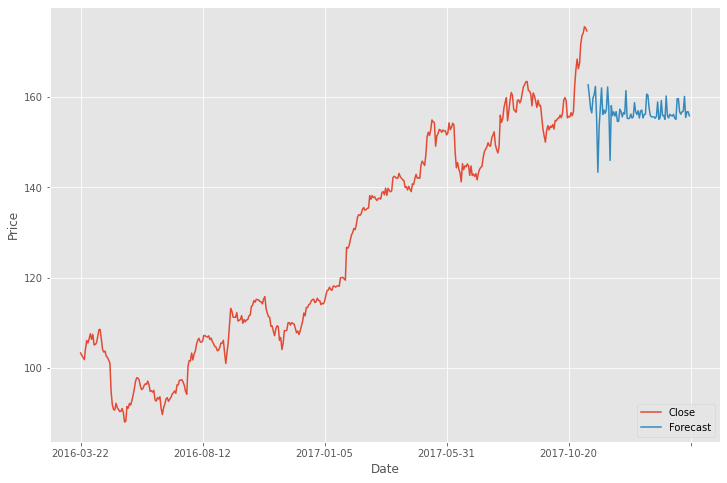

In [749]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = datetime.datetime.strptime(last_date, "%Y-%m-%d")
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

plt.figure(figsize=(12,8))
dfreg['Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see the blue color showcased the forecast on the stocks price. The forecast predicted that there would be a downturn. Therefore, we should not buy this stock for now!

### K Nearest Neighbour (KNN) - Evaluation (Classification)

Let's take a look at our processed data again. For this classification problem, we will set the label as either 'Up' or 'Down' depending on the next day's close price compared to today's.

In [750]:
dfclass = df.loc[:,['Close','Volume']]
dfclass['HL_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfclass['Percent_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfclass['Label'] = np.where(dfclass['Close']>dfclass['Close'].shift(-1), "Down", "Up")

dfclass.head(10)

,Close,Volume,HL_Percent,Percent_Change,Label
Date,,,,,
1984-09-07,0.42388,23220030,2.425215,0.000000,Down
1984-09-10,0.42134,18022532,2.729387,-0.599226,Up
1984-09-11,0.42902,42498199,2.685190,0.907893,Down
1984-09-12,0.41618,37125801,3.697919,-2.992867,Up
1984-09-13,0.43927,57822062,0.284563,0.000000,Up
1984-09-14,0.44566,68847968,3.448817,1.166803,Up
1984-09-17,0.45718,53755262,1.397699,0.000000,Down
1984-09-18,0.44052,27136886,4.655861,-3.644079,Down
1984-09-19,0.43157,29641922,3.264824,-2.031690,Up


In [751]:
X = np.array(dfclass.drop(['Label'], axis=1))
X = scaler.fit_transform(X)

y = np.array(dfclass['Label'])

# Separation of training and testing of model by train test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# KNN Classification
clfknn2 = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
clfknn2.fit(X_train, y_train)

print('kNN accuracy for training set: %f' % clfknn2.score(X_train, y_train))
print('kNN accuracy for test set: %f' % clfknn2.score(X_test, y_test))

kNN accuracy for training set: 0.658496
kNN accuracy for test set: 0.518231


Above shows an accuracy score (about 0.52) for our KNN model, which is slightly more that 50%. Hence we see that it is harder to predict using KNN with classification.

## 1. Predict 'Up' 'Down' (5 days later) based on price change rate of the past 30 days.
Another practical setting is to predict the return in a time period. Return of one month is defined as the price change rate, that is *price_of_month_end* - *price_of_month_start* / *price_of_month_start*. Then your problem is formulated as that (for example) given the past 3 years data (could be monthly return, then you have 36 time observations), the model is to predict next month’s return.

In [752]:
# Create a new column called 5th Day Close, where the value is either up or down depending on the close price of the 5th day from today.
#df['5th Day Close'] = np.where(df['Close'] > df['Close'].shift(-5), "Down", "Up")
#print(df.shape)
#df.head(10)

df["Diff"] = df.Close.diff()
df["SMA_2"] = df.Close.rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]
df["y"] = df["Diff"].apply(lambda x: 1 if x > 0 else 0).shift(-1)
#df = df.drop(
#   ["Open", "High", "Low", "Close", "Volume", "Diff"],
#   axis=1,
#).dropna()
df.head(10)

,Open,High,Low,Close,Volume,Diff,SMA_2,Force_Index,y
Date,,,,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,NaN,NaN,9.842506e+06,0.0
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,-0.00254,0.422610,7.593614e+06,1.0
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0.00768,0.425180,1.823258e+07,0.0
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,-0.01284,0.422600,1.545102e+07,1.0
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0.02309,0.427725,2.539950e+07,1.0
1984-09-14,0.44052,0.45589,0.44052,0.44566,68847968,0.00639,0.442465,3.068279e+07,1.0
1984-09-17,0.45718,0.46357,0.45718,0.45718,53755262,0.01152,0.451420,2.457583e+07,0.0
1984-09-18,0.45718,0.46103,0.44052,0.44052,27136886,-0.01666,0.448850,1.195434e+07,0.0
1984-09-19,0.44052,0.44566,0.43157,0.43157,29641922,-0.00895,0.436045,1.279256e+07,1.0
